© 2025 Mobile Perception Systems Lab at TU/e. All rights reserved. Licensed under the MIT License.

## Setup

In [1]:
import yaml
from lightning import seed_everything
import torch
from torch.nn import functional as F
from torch.amp.autocast_mode import autocast
import matplotlib.pyplot as plt
import numpy as np
from huggingface_hub import hf_hub_download
from huggingface_hub.utils import RepositoryNotFoundError
import warnings
import importlib

seed_everything(0, verbose=False)

device = 0  # TODO: change to the GPU you want to use
img_idx = 0  # TODO: change to the index of the image you want to visualize
config_path = (
    "configs/coco/panoptic/eomt_giant_1280.yaml"  # TODO: change to the config file
)
data_path = "/mnt/sda1/tkerssies"  # TODO: change to the dataset directory

with open(config_path, "r") as f:
    config = yaml.safe_load(f)


def create_mapping(images, ignore_index):
    unique_ids = np.unique(np.concatenate([np.unique(img) for img in images]))
    valid_ids = unique_ids[unique_ids != ignore_index]
    colors = np.array(
        [plt.cm.hsv(i / len(valid_ids))[:3] for i in range(len(valid_ids))]
    )
    mapping = {cid: colors[i] for i, cid in enumerate(valid_ids)}
    mapping[ignore_index] = np.array([0, 0, 0])
    return mapping


def apply_colormap(image, mapping):
    colored_image = np.zeros((*image.shape, 3))
    for cid in np.unique(image):
        colored_image[image == cid] = mapping.get(cid, [0, 0, 0])
    return colored_image

## Load dataset

Ensure the dataset files are correctly prepared and placed in the folder specified by `data_path`.

In [2]:
data_module_name, class_name = config["data"]["class_path"].rsplit(".", 1)
data_module = getattr(importlib.import_module(data_module_name), class_name)
data_module_kwargs = config["data"].get("init_args", {})

data = data_module(
    path=data_path,
    batch_size=1,
    num_workers=0,
    check_empty_targets=False,
    **data_module_kwargs
).setup()

## Load model

In [3]:
warnings.filterwarnings(
    "ignore",
    message=r".*Attribute 'network' is an instance of `nn\.Module` and is already saved during checkpointing.*",
)

# Load encoder
encoder_cfg = config["model"]["init_args"]["network"]["init_args"]["encoder"]
encoder_module_name, encoder_class_name = encoder_cfg["class_path"].rsplit(".", 1)
encoder_cls = getattr(importlib.import_module(encoder_module_name), encoder_class_name)
encoder = encoder_cls(img_size=data.img_size, **encoder_cfg.get("init_args", {}))

# Load network
network_cfg = config["model"]["init_args"]["network"]
network_module_name, network_class_name = network_cfg["class_path"].rsplit(".", 1)
network_cls = getattr(importlib.import_module(network_module_name), network_class_name)
network_kwargs = {k: v for k, v in network_cfg["init_args"].items() if k != "encoder"}
network = network_cls(
    masked_attn_enabled=False,
    num_classes=data.num_classes,
    encoder=encoder,
    **network_kwargs,
)

# Load Lightning module
lit_module_name, lit_class_name = config["model"]["class_path"].rsplit(".", 1)
lit_cls = getattr(importlib.import_module(lit_module_name), lit_class_name)
model_kwargs = {k: v for k, v in config["model"]["init_args"].items() if k != "network"}
if "stuff_classes" in config["data"].get("init_args", {}):
    model_kwargs["stuff_classes"] = config["data"]["init_args"]["stuff_classes"]

model = (
    lit_cls(
        img_size=data.img_size,
        num_classes=data.num_classes,
        network=network,
        **model_kwargs,
    )
    .eval()
    .to(device)
)

## Load pre-trained weights from Hugging Face Hub
The model weights are downloaded from the Hugging Face Hub using the logger name from the config. Make sure you have a working internet connection.

In [4]:
name = config.get("trainer", {}).get("logger", {}).get("init_args", {}).get("name")

if name is None:
    warnings.warn("No logger name found in the config. Please specify a model name.")
else:
    try:
        state_dict_path = hf_hub_download(
            repo_id=f"tue-mps/{name}",
            filename="pytorch_model.bin",
        )
        state_dict = torch.load(
            state_dict_path,
            map_location=torch.device(f"cuda:{device}"),
            weights_only=True,
        )
        model.load_state_dict(state_dict)
    except RepositoryNotFoundError:
        warnings.warn(
            f"Pre-trained model not found for `{name}`. Please load your own checkpoint."
        )

## Semantic inference (pixel-wise classification)

> This inference method also works when applied to a model trained for panoptic segmentation.

Semantic inference computes per-pixel class scores by combining mask and class predictions:

$$
\sum_i p_i(c) \cdot m_i[h, w]
$$

Here, $p_i(c)$ is the class probability for class $c$ (excluding "no object"), and $m_i[h, w]$ is the sigmoid-normalized mask value for query $i$ at pixel $(h, w)$. The final class is selected by taking the argmax over classes.  
  
*This inference method was originally introduced in MaskFormer.*

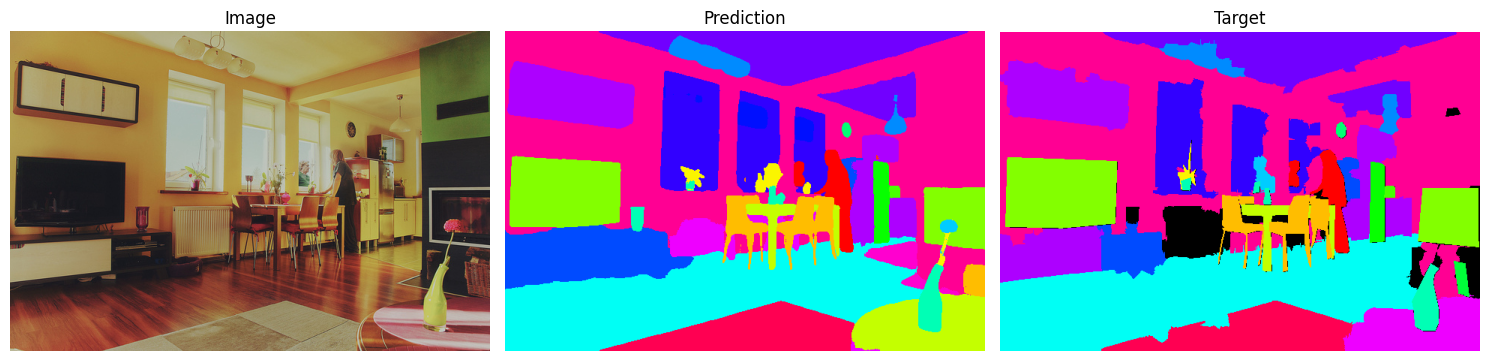

In [5]:
IGNORE_INDEX = 255


def infer_semantic(img, target):
    with torch.no_grad(), autocast(dtype=torch.float16, device_type="cuda"):
        imgs = [img.to(device)]
        img_sizes = [img.shape[-2:] for img in imgs]
        crops, origins = model.window_imgs_semantic(imgs)

        mask_logits_per_layer, class_logits_per_layer = model(crops)
        mask_logits = F.interpolate(
            mask_logits_per_layer[-1], data.img_size, mode="bilinear"
        )

        crop_logits = model.to_per_pixel_logits_semantic(
            mask_logits, class_logits_per_layer[-1]
        )
        logits = model.revert_window_logits_semantic(crop_logits, origins, img_sizes)
        preds = logits[0].argmax(0).cpu()

    pred_array = preds.numpy()
    target_array = model.to_per_pixel_targets_semantic([target], IGNORE_INDEX)[
        0
    ].numpy()
    return pred_array, target_array


def plot_semantic_results(img, pred_array, target_array):
    mapping = create_mapping([pred_array, target_array], IGNORE_INDEX)

    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    axes[0].imshow(img.permute(1, 2, 0).cpu().numpy())
    axes[0].set_title("Image")
    axes[1].imshow(apply_colormap(pred_array, mapping))
    axes[1].set_title("Prediction")
    axes[2].imshow(apply_colormap(target_array, mapping))
    axes[2].set_title("Target")

    for ax in axes:
        ax.axis("off")

    plt.tight_layout()
    plt.show()


img, target = data.val_dataloader().dataset[img_idx]
pred_array, target_array = infer_semantic(img, target)
plot_semantic_results(img, pred_array, target_array)

## Panoptic inference (segmentation with instance IDs)

> This inference method also works when applied to a model trained for instance segmentation.

Panoptic inference assigns each pixel $[h, w]$ to the query $i$ that maximizes the product of class and mask confidence:

$$
p_i(c_i) \cdot m_i[h, w]
$$

where $c_i = \arg\max_c \, p_i(c)$ is the most likely class for query $i$. A pixel is assigned to a query only if both the class confidence and mask confidence are high. Pixels assigned to the same query form a segment labeled with $c_i$. "Stuff" segments with the same class are merged; "thing" segments are kept distinct using the query index. Low-confidence and heavily occluded predictions are filtered out.  
  
*This inference method was originally introduced in MaskFormer.*

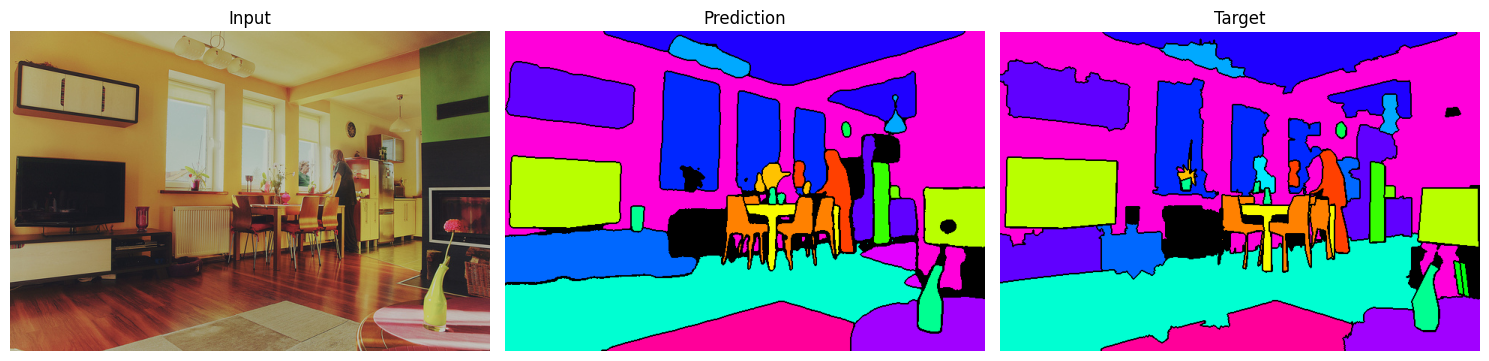

In [6]:
def infer_panoptic(img, target):
    with torch.no_grad(), autocast(dtype=torch.float16, device_type="cuda"):
        imgs = [img.to(device)]
        img_sizes = [img.shape[-2:] for img in imgs]

        transformed_imgs = model.resize_and_pad_imgs_instance_panoptic(imgs)
        mask_logits_per_layer, class_logits_per_layer = model(transformed_imgs)
        mask_logits = F.interpolate(
            mask_logits_per_layer[-1], model.img_size, mode="bilinear"
        )
        mask_logits = model.revert_resize_and_pad_logits_instance_panoptic(
            mask_logits, img_sizes
        )

        preds = model.to_per_pixel_preds_panoptic(
            mask_logits,
            class_logits_per_layer[-1],
            model.stuff_classes,
            model.mask_thresh,
            model.overlap_thresh,
        )[0].cpu()

    pred = preds.numpy()
    sem_pred, inst_pred = pred[..., 0], pred[..., 1]

    target_seg = model.to_per_pixel_targets_panoptic([target])[0].cpu().numpy()
    sem_target, inst_target = target_seg[..., 0], target_seg[..., 1]

    return sem_pred, inst_pred, sem_target, inst_target


def draw_black_border(sem, inst, mapping):
    h, w = sem.shape
    out = np.zeros((h, w, 3))
    for s in np.unique(sem):
        out[sem == s] = mapping[s]

    combined = sem.astype(np.int64) * 100000 + inst.astype(np.int64)
    border = np.zeros((h, w), dtype=bool)
    border[1:, :] |= combined[1:, :] != combined[:-1, :]
    border[:-1, :] |= combined[1:, :] != combined[:-1, :]
    border[:, 1:] |= combined[:, 1:] != combined[:, :-1]
    border[:, :-1] |= combined[:, 1:] != combined[:, :-1]
    out[border] = 0
    return out


def plot_panoptic_results(img, sem_pred, inst_pred, sem_target, inst_target):
    all_ids = np.union1d(np.unique(sem_pred), np.unique(sem_target))
    mapping = {
        s: (
            [0, 0, 0]
            if s == -1 or s == model.num_classes
            else plt.cm.hsv(i / len(all_ids))[:3]
        )
        for i, s in enumerate(all_ids)
    }

    vis_pred = draw_black_border(sem_pred, inst_pred, mapping)
    vis_target = draw_black_border(sem_target, inst_target, mapping)

    img_np = (
        img.cpu().numpy().transpose(1, 2, 0) if img.dim() == 3 else img.cpu().numpy()
    )

    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    axes[0].imshow(img_np)
    axes[0].set_title("Input")
    axes[1].imshow(vis_pred)
    axes[1].set_title("Prediction")
    axes[2].imshow(vis_target)
    axes[2].set_title("Target")

    for ax in axes:
        ax.axis("off")

    plt.tight_layout()
    plt.show()


img, target = data.val_dataloader().dataset[img_idx]
sem_pred, inst_pred, sem_target, inst_target = infer_panoptic(img, target)
plot_panoptic_results(img, sem_pred, inst_pred, sem_target, inst_target)